In [1]:
# Example using sunkit-spex with files from the RHESSI archive
# https://hesperia.gsfc.nasa.gov/rhessi3/mission-archive/index.html

# Note that these are two types of spectra/srm files:
# Standard Energy Resolution - 
# 1). For every orbit of the RHESSI mission (midnight-to-midnight), count spectrum files 
# with 4s bins, 77 energy bins 3-250 keV, combining all functional detectors (front segment only). 
# For every flare, there are Spectral Response Matrix (SRM) files with the same energy bins 
# and the same combined detector segments as in those spectrum files.
# 
# 2). High Energy Resolution - For the larger RHESSI flares (events seen above 50 keV), 
# count spectrum files for the orbit containing the flare (midnight-to-midnight) 
# for each separate detector (front segment only), with 4s time bins and energy bins 
# from 3 keV to 3 MeV, starting with 1/3 keV bins up to 15 keV and larger bins for 
# higher energies, but finer bins surrounding each line. A combined-detector (all functional front detectors) 
# file is also provided. The corresponding Spectral Response Matrix (SRM) files are also provided. (more info)
# 
# Here testing with the microflare from 17-Nov-2006 about 05:13
# From https://umbra.nascom.nasa.gov/rhessi/rhessi_extras/spectra/fits_standard/2006/11/17/hsi_spectrum_20061117_0419_0555_3_250keV_alld.fits
# From https://umbra.nascom.nasa.gov/rhessi/rhessi_extras/spectra/fits_standard/2006/11/17/hsi_srm_20061117_0512_0516_3_250keV_alld.fits
# 
# 23-Jan-2025 IGH
# 27-Jan-2025 IGH - need >200 keV bug fixed in thermal model for fitting to work

In [2]:
from astropy.time import Time, TimeDelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sunpy.io.special import read_genx
# Note this load in is a WIP during the refactor/rename
# works with v0.4.1.dev21
from sunkit_spex.extern.rhessi import RhessiLoader
from sunkit_spex.legacy.fitting.fitter import Fitter

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

plt.rcParams.update({'font.size': 18,'mathtext.default':"regular"})

In [3]:
# Some setup for sunxspex
time_profile_size = (9,6)
spec_single_plot_size = (6,8)
spec_plot_size = (16,10)
spec_font_size = 18
default_font_size = 10
xlims, ylims = [3,30], [5e-2,3e4]
tol = 1e-5

# Where are the spec and srm fits files ???
# On server
# _dir = "wee_flares/fits/"+fname[:4]+"/"+fname[4:6]+"/"
# just locally for testing
# _dir = "/Users/iain/github/sks_examples/fits/"
_dir = "fits/"
specname=_dir+"hsi_spectrum_20061117_0419_0555_3_250keV_alld.fits"
srmname=_dir+"hsi_srm_20061117_0512_0516_3_250keV_alld.fits"

In [4]:
# Use the background and flare times from the weeflare list
ftims=Time(['2006-11-17T05:13:30.000','2006-11-17T05:13:46.000'],format='isot')
btims=Time(['2006-11-17T05:11:50.000','2006-11-17T05:12:06.000'],format='isot')

In [5]:
rhess_spec = RhessiLoader(spectrum_fn=specname, srm_fn=srmname)

In [6]:
# Whats the energy range of the file
print(rhess_spec._loaded_spec_data["count_channel_bins"][0][0])
print(rhess_spec._loaded_spec_data["count_channel_bins"][-1][-1])

3.0
250.0


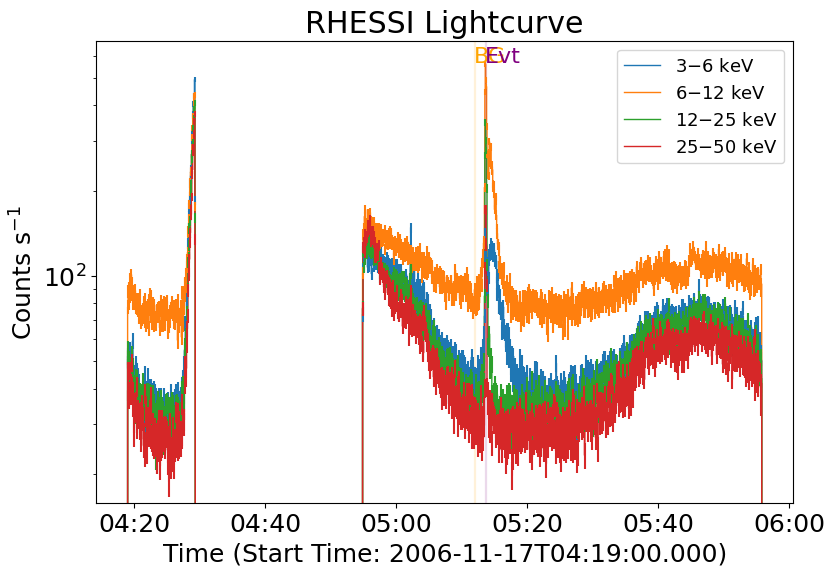

In [7]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
rhess_spec.update_background_times(btims[0],btims[1])
rhess_spec.update_event_times(ftims[0],ftims[1])
rhess_spec.lightcurve(energy_ranges=[[3,6], [6,12], [12,25], [25,50]])
plt.show()
plt.rcParams['font.size'] = default_font_size

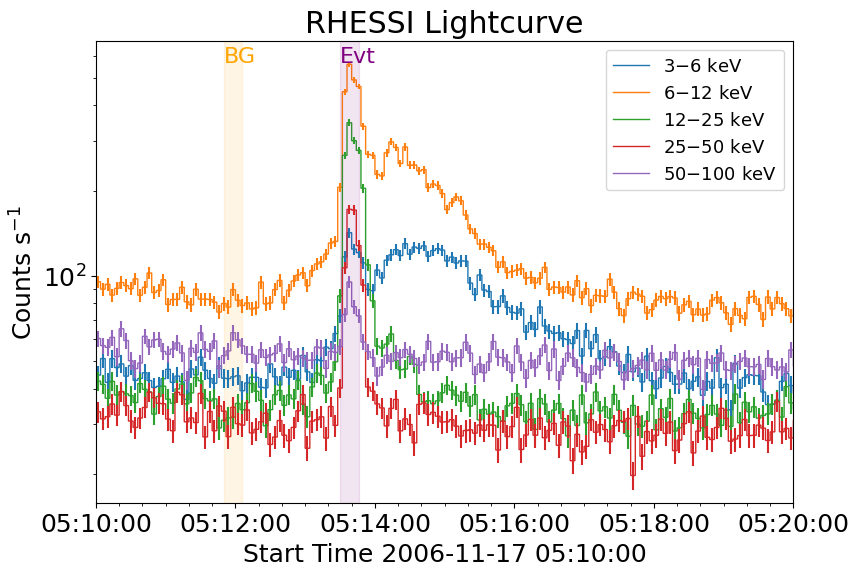

In [8]:
# Let's zoom into the time of the flare
# And then also need to manually change the xlabel and xmajor ticks

tr=Time(['2006-11-17T05:10:00.000','2006-11-17T05:20:00.000'],format='isot')
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
rhess_spec.update_background_times(btims[0],btims[1])
rhess_spec.update_event_times(ftims[0],ftims[1])
ax=rhess_spec.lightcurve(energy_ranges=[[3,6], [6,12], [12,25], [25,50],[50,100]])
ax.set_xlim(tr[0].datetime,tr[1].datetime)
ax.set_xlabel("Start Time "+tr[0].iso[:19])
ax.xaxis.set_minor_locator(matplotlib.dates.SecondLocator(interval=20))
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
plt.show()
plt.rcParams['font.size'] = default_font_size

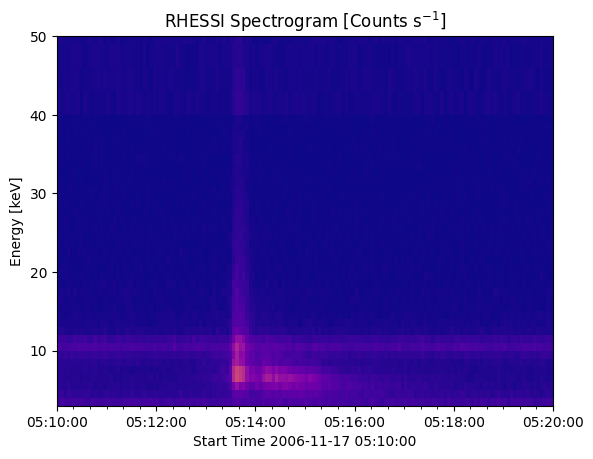

In [9]:
# Plot is as a spectrogram instead....
ax=rhess_spec.spectrogram()
ax.set_ylim(3,50)
ax.set_xlim(tr[0].datetime,tr[1].datetime)
ax.set_xlabel("Start Time "+tr[0].iso[:19])
ax.xaxis.set_minor_locator(matplotlib.dates.SecondLocator(interval=20))
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
plt.show()

In [10]:
#  No do the fitting
fitter = Fitter(rhess_spec)
fitter.model = "(f_vth+thick_fn)"
fitter.loglikelihood = "cstat"
fitter.show_params

Param,Status,Value,Bounds,Error
,,,"(min, max)","(-, +)"
str22,str11,float64,object,object
T1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
EM1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
total_eflux1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
index1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
e_c1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
Fit Stat.,cstat ln(L),0.00e+00,--,--


In [11]:
# So need fix for the thermal model to do >200 keV as data here goes upto 250 keV....
rhess_spec._loaded_spec_data["count_channel_bins"][-1][-1]

# Just fit thermal part first and set the bounds
fitter.energy_fitting_range = [4,8]
fitter.params["T1_spectrum1"] = {"Value":10, "Bounds":(7, 20)}
fitter.params["EM1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e2)}
fitter.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.9, "Bounds":(1e-2, 1e2)}
fitter.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(3, 12)}
fitter.params["e_c1_spectrum1"] = {"Status":"fix", "Value":15, "Bounds":(7, 30)}
spec_fit = fitter.fit()

# Then non-thermal fit higher energy
fitter.energy_fitting_range = [20,50]
fitter.params["T1_spectrum1"] = "fix"
fitter.params["EM1_spectrum1"] = "fix"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

# The do the full range
fitter.energy_fitting_range = [4,50]
fitter.params["T1_spectrum1"] = "free"
fitter.params["EM1_spectrum1"] = "free"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

ValueError: All input energy values must be within the range 1.0002920302956426--200.15819869050395 keV. 